<a href="https://colab.research.google.com/github/MocktaiLEngineer/100-days-of-GenAI/blob/main/Day_5_Neural_Probabilistic_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# Get the names.txt file
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-03-30 09:07:09--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.06s   

2023-03-30 09:07:10 (3.57 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
TOKEN = '.'
vocab = [TOKEN] + sorted(set(''.join(words)))

char_to_int = {char:i for i,char in enumerate(vocab)}
int_to_char = {i:char for char,i in char_to_int.items()}

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = char_to_int[ch]
      X.append(context)
      Y.append(ix)
    #   print(''.join(int_to_char[i] for i in context), '--->', int_to_char[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [6]:
X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [7]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
n = len(vocab)
num_dimensions = 2

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((n, num_dimensions), generator = g ) # Embedding table C, which aims to represent the embedding for each character in the vocab
W1 = torch.randn((num_dimensions * block_size, 100), generator = g)
W2 = torch.randn((100, n), generator = g)
b1 = torch.randn((100), generator = g)
b2 = torch.randn((27), generator = g)

parameters = [C, W1, W2, b1, b2]
num_of_parameters = sum(p.nelement() for p in parameters)
num_of_parameters

for p in parameters:
    p.requires_grad = True

In [9]:
batch_size = 32

for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    print(f"{loss=}")
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    # Update
    for p in parameters:
        p.data += -lr * p.grad

Streaming output truncated to the last 5000 lines.
loss=tensor(1.7220, grad_fn=<NllLossBackward0>)
loss=tensor(2.0750, grad_fn=<NllLossBackward0>)
loss=tensor(2.3974, grad_fn=<NllLossBackward0>)
loss=tensor(1.9565, grad_fn=<NllLossBackward0>)
loss=tensor(2.3134, grad_fn=<NllLossBackward0>)
loss=tensor(2.3716, grad_fn=<NllLossBackward0>)
loss=tensor(1.6857, grad_fn=<NllLossBackward0>)
loss=tensor(2.1739, grad_fn=<NllLossBackward0>)
loss=tensor(2.2722, grad_fn=<NllLossBackward0>)
loss=tensor(2.1057, grad_fn=<NllLossBackward0>)
loss=tensor(2.1906, grad_fn=<NllLossBackward0>)
loss=tensor(2.4040, grad_fn=<NllLossBackward0>)
loss=tensor(2.1512, grad_fn=<NllLossBackward0>)
loss=tensor(2.4126, grad_fn=<NllLossBackward0>)
loss=tensor(2.3183, grad_fn=<NllLossBackward0>)
loss=tensor(1.9944, grad_fn=<NllLossBackward0>)
loss=tensor(2.5905, grad_fn=<NllLossBackward0>)
loss=tensor(2.1087, grad_fn=<NllLossBackward0>)
loss=tensor(2.1011, grad_fn=<NllLossBackward0>)
loss=tensor(2.0519, grad_fn=<NllLossB

In [10]:
# training loss 
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.2486, grad_fn=<NllLossBackward0>)

In [11]:
# validation loss
emb = C[X_val] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.2551, grad_fn=<NllLossBackward0>)

In [12]:
# test loss
emb = C[X_test] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_test)
loss

tensor(2.2530, grad_fn=<NllLossBackward0>)

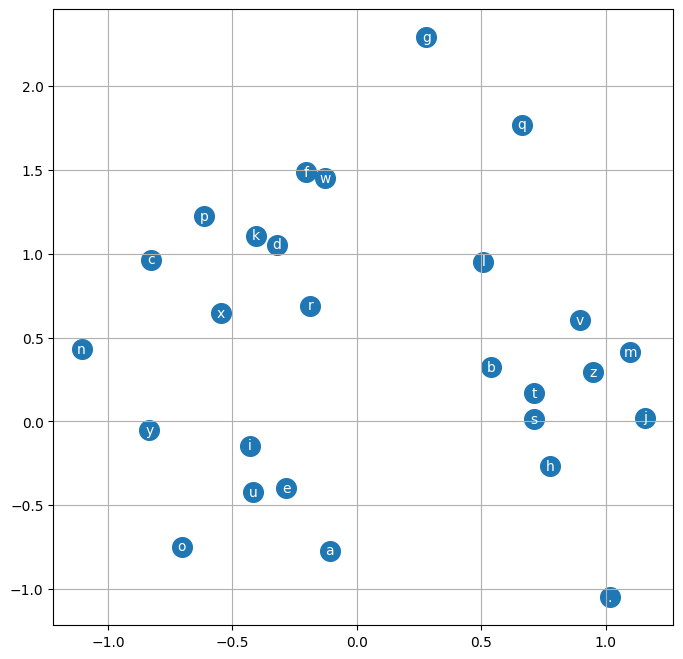

In [13]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), int_to_char[i], ha="center", va="center", color='white')
plt.grid('minor')

In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(int_to_char[i] for i in out))

carlah.
amille.
khi.
mrix.
thty.
sacassa.
jazonte.
dellynt.
kaeli.
nellaishchaiir.
kaleighh.
lur.
kin.
quinn.
sroilea.
jadiqui.
jero.
dearynix.
kaeliighan.
edde.
